In [3]:
# Parameters
artificial_humans = "../../model/artificial_humans/01_rnn_edge_features/rnn_True__edge_True__global_features_False.pt"
artificial_humans_model = "graph"
managers = {
    "humanlike": {
        "type": "human",
        "path": "../../model/human_like_manager/03_features_features_cont+ppun+valid.pt",
    },
    "optimal": {
        "type": "rl",
        "path": "../../model/manager/17_model__rnn_True__edge_False__global_features_False__run_0.pt",
    },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 1000


In [4]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def mem_to_df(recorder, name):
    columns = ['round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')

    df_sim = punishments.merge(common_good).merge(contributions)

    df_sim['data_source'] = name
    return df_sim

def make_round(contributions, groups, round):
    return {
        'contributions': contributions,
        'missing_inputs': [c is None for c in contributions],
        'manager_missing_inputs': [True] * len(contributions),
        'punishments': [None] * len(contributions),
        'groups': groups,
        'round': round,
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishments': punishments,
        'manager_missing_inputs': [p is None for p in punishments],
    }


In [6]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)
mm = MultiManager(managers)

runs = {
    **{
    f'hm #{n}':['humanlike'] * n for n in range(3,8)
    }, **{
    f'om #{n}':['optimal'] * n for n in range(3,8)
    }, 
    'mixed': ['humanlike'] * 4 + ['optimal'] * 4
}

dfs = []
for name, groups in runs.items():
    n_agents = len(groups)
    env = ArtificialHumanEnv(
        artifical_humans=artifical_humans, n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        rounds = []
        for round_number in count():
            contributions = state['contributions'].squeeze().tolist()
            round = make_round(contributions, groups, round_number)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments)
            recorder.add(
                **{k: v.squeeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [28]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
experiment_names = ['trail_rounds_2']

df_pilot = pd.read_csv(data_file)

# df_pilot = df_pilot[df_pilot['experiment_name'].isin(experiment_names)]
df_pilot['data_source'] = 'pilot ' + df_pilot['experiment_name']

columns = ['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'data_source']

df = pd.concat([*dfs, df_pilot[columns]]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source'], 
    value_vars=['punishment', 'contribution'])

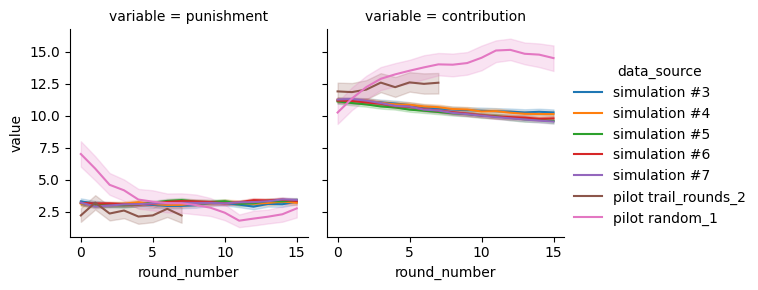

In [29]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=3, aspect=1,
)


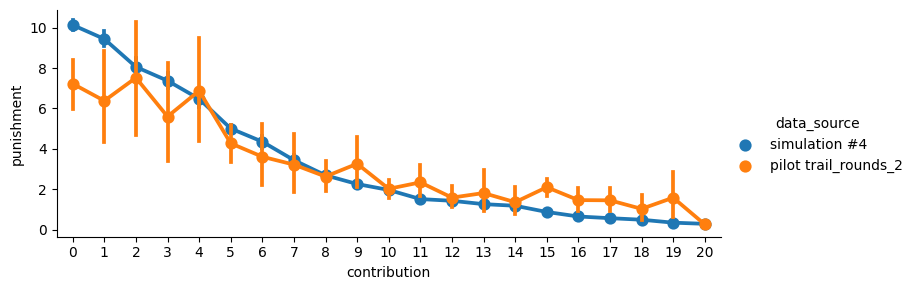

In [31]:
df['contribution'] = df['contribution'].astype(int)
g = sns.catplot(
    data=df[df['data_source'].isin(['simulation #4', 'pilot trail_rounds_2'])],
    x="contribution", 
    y="punishment",
    hue='data_source',
    kind="point",
    height=3, aspect=2.5,
)